In [2]:
import importlib

import indra_gpt.chat_curate.chat_curate
importlib.reload(indra_gpt.chat_curate.chat_curate)
from indra_gpt.chat_curate.chat_curate import *

import indra_gpt.chat_curate.eval
importlib.reload(indra_gpt.chat_curate.eval)
from indra_gpt.chat_curate.eval import *

import pickle
from pathlib import Path

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np


/Users/thomaslim/miniconda3/envs/indra_gpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: [2025-07-03 10:12:01] httpx - HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


In [2]:
RESULTS_DIR = Path.cwd().joinpath("output/curated_statements_sample_100")
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir(parents=True)


In [ ]:
# # Get all curated statements
# curations = indra_db_rest.get_curations()
# all_curation_hashes = list({c['pa_hash'] for c in curations if 'pa_hash' in c})

# CHUNK_SIZE = 1000
# chunks = [all_curation_hashes[i:i + CHUNK_SIZE] for i in range(0, len(all_curation_hashes), CHUNK_SIZE)]

# stmts = []
# for i, chunk in tqdm(enumerate(chunks), total=len(chunks), desc=f"Processing chunk..."):
#     stmt_proc = indra_db_rest.get_statements_by_hash(chunk, ev_limit=1000)
#     chunk_statements = stmt_proc.statements
#     stmts.extend(chunk_statements)

# # Save to pickle
# output_path = RESULTS_DIR / 'curated_statements_all.pkl'

# with open(output_path, "wb") as f:
#     pickle.dump(stmts, f)

# print(f"✅ Saved {len(stmts)} curated statements to: {output_path}")


INFO: [2025-07-02 13:29:15] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list
INFO: [2025-07-02 13:29:15] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-02 13:29:15] indra.sources.indra_db_rest.util - data: None
Processing chunk...:   0%|          | 0/11 [00:00<?, ?it/s]INFO: [2025-07-02 13:29:17] indra_db_rest.query_processor - Retrieving statements that have hash -10418861028177660, -10504370311001185, -10523634476414497, -10680394127178967, -10741970456116654, -10762252061146643, -1077160338061446, -10825589495626679, -10959681589279843, -11004743610267597, -11087243028036330, -11227751069906032, -11265666722889433, -11333047471437427, -11353752672662613, -11362201110477232, -11397969923439383, -11449991866579292, -1153910204725972, -11576774002472009, -11680321630863315, -11720230643824146, -11727479607000094, -12006112775372697, -12064636854697961, -12229703460584797, -12231047786266024, -12249652704673362, -1231821899

✅ Saved 8447 curated statements to: /Users/thomaslim/gyorilab/indra_gpt/output/curated_statements_sample_100/all_curated_statements.pkl


In [ ]:
# curated_statements_all = pickle.load(open(RESULTS_DIR.joinpath("curated_statements_all.pkl"), "rb"))
# for n_evidence_to_curate in [2, 4, 6, 8, 10]:
#     curated_statements_min_evidence = []
#     for stmt in curated_statements_all:
#         if len(stmt.evidence) >= n_evidence_to_curate:
#             curated_statements_min_evidence.append(stmt)

#     # Sample 100 statements
#     rng = random.Random(42)  # For reproducibility
#     curated_statements_min_evidence_sample = rng.sample(curated_statements_min_evidence, min(100, len(curated_statements_min_evidence)))
    
#     # Save to pickle
#     output_path = RESULTS_DIR / f"curated_statements_min_evidence_{n_evidence_to_curate}_sample_100.pkl"

#     with open(output_path, "wb") as f:
#         pickle.dump(curated_statements_min_evidence_sample, f)

#     print(f"✅ Saved {len(curated_statements_min_evidence_sample)} curated statements to: {output_path}")


✅ Saved 100 curated statements to: /Users/thomaslim/gyorilab/indra_gpt/output/curated_statements_sample_100/curated_statements_min_evidence_2_sample_100.pkl
✅ Saved 100 curated statements to: /Users/thomaslim/gyorilab/indra_gpt/output/curated_statements_sample_100/curated_statements_min_evidence_4_sample_100.pkl
✅ Saved 100 curated statements to: /Users/thomaslim/gyorilab/indra_gpt/output/curated_statements_sample_100/curated_statements_min_evidence_6_sample_100.pkl
✅ Saved 100 curated statements to: /Users/thomaslim/gyorilab/indra_gpt/output/curated_statements_sample_100/curated_statements_min_evidence_8_sample_100.pkl
✅ Saved 100 curated statements to: /Users/thomaslim/gyorilab/indra_gpt/output/curated_statements_sample_100/curated_statements_min_evidence_10_sample_100.pkl


In [ ]:
models = ['gpt-4o-mini']
for model in models:
    for n_evidence_to_curate in [2, 4, 6, 8, 10]:
        print(f"Curating statements with {n_evidence_to_curate} evidences using model: {model}")
        # Load the curated statements from the pickle file
        with open(RESULTS_DIR / f"curated_statements_min_evidence_10_sample_100.pkl", "rb") as f:
            curated_statements = pickle.load(f)

        # Now curate the statements using the chat model
        llm_curations_binary = chat_curate_stmts(curated_statements,
                                        n_evidence_to_curate=n_evidence_to_curate,
                                        decision_threshold=0.5,
                                        binary_classification=True,
                                        #ignore_tags=['incorrect'],
                                        n_fewshot_examples=2,
                                        get_ex_per_tag=True,
                                        schema_output_mode=True,
                                        model=model)
        llm_curations_multiclass = chat_curate_stmts(curated_statements,
                                        n_evidence_to_curate=n_evidence_to_curate,
                                        decision_threshold=0.5,
                                        binary_classification=False,
                                        ignore_tags=['incorrect'],
                                        n_fewshot_examples=2,
                                        get_ex_per_tag=True,
                                        schema_output_mode=True,
                                        model=model)

        if not RESULTS_DIR.joinpath(model).joinpath(f"num_evidence_{n_evidence_to_curate}").exists():
            RESULTS_DIR.joinpath(model).joinpath(f"num_evidence_{n_evidence_to_curate}").mkdir(parents=True)
        with open(RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}" / "chat_curation_binary_classification.json", "w") as f:
            json.dump(llm_curations_binary, f, indent=2)
        with open(RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}" / "chat_curation_multiclass_classification.json", "w") as f:
            json.dump(llm_curations_multiclass, f, indent=2)


Curating statements with 2 evidences using model: gpt-4o-mini


Generating prompts...:  24%|██▍       | 24/100 [01:33<04:28,  3.54s/it]INFO: [2025-07-02 13:46:49] indra_gpt.chat_curate.chat_curate - Skipping evidence with no text for statement 1270149867165881: Evidence(source_api='biopax',
         source_id='http://www.phosphosite.org/phosphosite.owl#Catalysis_65958103_775',
         annotations={
                      "source_sub_id": "phosphositeplus",
                      "agents": {
                       "raw_text": [
                        null,
                        null
                       ]
                      },
                      "prior_uuids": [
                       "91fea392-f13e-46d3-9449-ea02555a1b47"
                      ]
                     },
         epistemics={
                     "direct": true
                    }
         )


Generating prompts...:  37%|███▋      | 37/100 [02:15<03:41,  3.52s/it]INFO: [2025-07-02 13:47:28] indra_gpt.chat_curate.chat_curate - Skipping agent None with no db_refs or None va

Curating statements with 4 evidences using model: gpt-4o-mini


Generating prompts...:  22%|██▏       | 22/100 [02:26<08:07,  6.26s/it]INFO: [2025-07-02 14:05:39] indra_gpt.chat_curate.chat_curate - Skipping evidence with no text for statement -34028544407902793: Evidence(source_api='biogrid',
         pmid='24289923',
         source_id='955656',
         annotations={
                      "biogrid_int_id": "955656",
                      "entrez_a": "29789",
                      "entrez_b": "580",
                      "biogrid_a": "118917",
                      "biogrid_b": "107056",
                      "syst_name_a": "PTD004",
                      "syst_name_b": null,
                      "hgnc_a": "OLA1",
                      "hgnc_b": "BARD1",
                      "syn_a": "DOC45|GBP45|GTBP9|GTPBP9",
                      "syn_b": null,
                      "exp_system": "Reconstituted Complex",
                      "exp_system_type": "physical",
                      "author": "Matsuzawa A (2014)",
                      "pmid": "2

Curating statements with 6 evidences using model: gpt-4o-mini


Generating prompts...:  22%|██▏       | 22/100 [03:43<12:31,  9.64s/it]INFO: [2025-07-02 14:41:21] indra_gpt.chat_curate.chat_curate - Skipping evidence with no text for statement -34028544407902793: Evidence(source_api='biogrid',
         pmid='24289923',
         source_id='955656',
         annotations={
                      "biogrid_int_id": "955656",
                      "entrez_a": "29789",
                      "entrez_b": "580",
                      "biogrid_a": "118917",
                      "biogrid_b": "107056",
                      "syst_name_a": "PTD004",
                      "syst_name_b": null,
                      "hgnc_a": "OLA1",
                      "hgnc_b": "BARD1",
                      "syn_a": "DOC45|GBP45|GTBP9|GTPBP9",
                      "syn_b": null,
                      "exp_system": "Reconstituted Complex",
                      "exp_system_type": "physical",
                      "author": "Matsuzawa A (2014)",
                      "pmid": "2

Curating statements with 8 evidences using model: gpt-4o-mini


Generating prompts...:  22%|██▏       | 22/100 [04:55<16:25, 12.63s/it]INFO: [2025-07-02 15:35:07] indra_gpt.chat_curate.chat_curate - Skipping evidence with no text for statement -34028544407902793: Evidence(source_api='biogrid',
         pmid='24289923',
         source_id='955655',
         annotations={
                      "biogrid_int_id": "955655",
                      "entrez_a": "580",
                      "entrez_b": "29789",
                      "biogrid_a": "107056",
                      "biogrid_b": "118917",
                      "syst_name_a": null,
                      "syst_name_b": "PTD004",
                      "hgnc_a": "BARD1",
                      "hgnc_b": "OLA1",
                      "syn_a": null,
                      "syn_b": "DOC45|GBP45|GTBP9|GTPBP9",
                      "exp_system": "Affinity Capture-Western",
                      "exp_system_type": "physical",
                      "author": "Matsuzawa A (2014)",
                      "pmid":

Curating statements with 10 evidences using model: gpt-4o-mini


Generating prompts...:  22%|██▏       | 22/100 [06:23<20:58, 16.14s/it]INFO: [2025-07-02 16:41:10] indra_gpt.chat_curate.chat_curate - Skipping evidence with no text for statement -34028544407902793: Evidence(source_api='biogrid',
         pmid='24289923',
         source_id='955655',
         annotations={
                      "biogrid_int_id": "955655",
                      "entrez_a": "580",
                      "entrez_b": "29789",
                      "biogrid_a": "107056",
                      "biogrid_b": "118917",
                      "syst_name_a": null,
                      "syst_name_b": "PTD004",
                      "hgnc_a": "BARD1",
                      "hgnc_b": "OLA1",
                      "syn_a": null,
                      "syn_b": "DOC45|GBP45|GTBP9|GTPBP9",
                      "exp_system": "Affinity Capture-Western",
                      "exp_system_type": "physical",
                      "author": "Matsuzawa A (2014)",
                      "pmid":

KeyboardInterrupt: 

22:37:07 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
INFO: [2025-07-02 22:37:07] LiteLLM - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
22:37:07 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
INFO: [2025-07-02 22:37:07] LiteLLM - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
22:37:08 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
INFO: [2025-07-02 22:37:08] LiteLLM - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
22:37:08 - LiteLLM:INFO: cost_calculator.py:655 - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
INFO: [2025-07-02 22:37:08] LiteLLM - selected model name for cost calculation: openai/gpt-4o-mini-2024-07-18
22:37:09 - LiteLLM:INFO: cost_calculator.py:655 - selected model name fo

In [7]:
with open(RESULTS_DIR / f"curated_statements_min_evidence_10_sample_100.pkl", "rb") as f:
    curated_statements = pickle.load(f)
n_evidence_to_curate = 10
llm_curations_multiclass = chat_curate_stmts(curated_statements,
                                        n_evidence_to_curate=n_evidence_to_curate,
                                        decision_threshold=0.5,
                                        binary_classification=False,
                                        ignore_tags=['incorrect'],
                                        n_fewshot_examples=2,
                                        get_ex_per_tag=True,
                                        schema_output_mode=True,
                                        model='gpt-4o-mini')
if not RESULTS_DIR.joinpath(model).joinpath(f"num_evidence_{n_evidence_to_curate}").exists():
    RESULTS_DIR.joinpath(model).joinpath(f"num_evidence_{n_evidence_to_curate}").mkdir(parents=True)
with open(RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}" / "chat_curation_multiclass_classification.json", "w") as f:
    json.dump(llm_curations_multiclass, f, indent=2)


Generating prompts...:  22%|██▏       | 22/100 [07:25<25:29, 19.60s/it]INFO: [2025-07-02 22:13:19] indra_gpt.chat_curate.chat_curate - Skipping evidence with no text for statement -34028544407902793: Evidence(source_api='biogrid',
         pmid='24289923',
         source_id='955656',
         annotations={
                      "biogrid_int_id": "955656",
                      "entrez_a": "29789",
                      "entrez_b": "580",
                      "biogrid_a": "118917",
                      "biogrid_b": "107056",
                      "syst_name_a": "PTD004",
                      "syst_name_b": null,
                      "hgnc_a": "OLA1",
                      "hgnc_b": "BARD1",
                      "syn_a": "DOC45|GBP45|GTBP9|GTPBP9",
                      "syn_b": null,
                      "exp_system": "Reconstituted Complex",
                      "exp_system_type": "physical",
                      "author": "Matsuzawa A (2014)",
                      "pmid": "2

In [8]:
# Store accuracy for plotting
accuracy_data = {model: {'binary': [], 'multiclass': []} for model in models}
evidence_counts = [2, 4, 6, 8, 10]

for model in models:
    for n_evidence_to_curate in evidence_counts:
        base_path = RESULTS_DIR / model / f"num_evidence_{n_evidence_to_curate}"

        with open(base_path / "chat_curation_binary_classification.json", "r") as f:
            chat_curation_binary_classification = json.load(f)
        with open(base_path / "chat_curation_multiclass_classification.json", "r") as f:
            chat_curation_multiclass_classification = json.load(f)

        # Evaluate and save comparison
        eval_stmt_binary = curation_statement_comparison_json(chat_curation_binary_classification)
        with open(base_path / "eval_stmt_chat_curation_binary_classification.json", "w") as f:
            json.dump(eval_stmt_binary, f, indent=2)

        eval_stmt_multi = curation_statement_comparison_json(chat_curation_multiclass_classification)
        with open(base_path / "eval_stmt_chat_curation_multiclass_classification.json", "w") as f:
            json.dump(eval_stmt_multi, f, indent=2)

        print(f"\nModel: {model}, Num Evidence: {n_evidence_to_curate}")
        for eval_strat, label in [('binary_classification', 'binary'), ('multiclass_classification', 'multiclass')]:
            with open(base_path / f"eval_stmt_chat_curation_{eval_strat}.json", "r") as f:
                res = json.load(f)
            preds = [item['llm_overall_prediction'] for item in res]
            labels = [item['indra_curation'] for item in res]
            acc = accuracy_score(labels, preds)
            accuracy_data[model][label].append(acc)
            print(f"{eval_strat} - Accuracy: {acc:.4f}")


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-03 08:38:34] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/14410654182566786
INFO: [2025-07-03 08:38:34] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:38:34] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<01:19,  1.25it/s]INFO: [2025-07-03 08:38:34] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/25933385922384546
INFO: [2025-07-03 08:38:34] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:38:34] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:01<00:53,  1.84it/s]INFO: [2025-07-03 08:38:35] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/32559174655542721
INFO: [2025-07-03 08:38:35] indra.sources.indra_db_rest.util - params: {'api_key


Model: gpt-4o-mini, Num Evidence: 2
binary_classification - Accuracy: 0.8400
multiclass_classification - Accuracy: 0.8200


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-03 08:39:35] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/14410654182566786
INFO: [2025-07-03 08:39:35] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:39:35] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:23,  4.16it/s]INFO: [2025-07-03 08:39:36] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/25933385922384546
INFO: [2025-07-03 08:39:36] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:39:36] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:35,  2.76it/s]INFO: [2025-07-03 08:39:36] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/32559174655542721
INFO: [2025-07-03 08:39:36] indra.sources.indra_db_rest.util - params: {'api_key


Model: gpt-4o-mini, Num Evidence: 4
binary_classification - Accuracy: 0.8200
multiclass_classification - Accuracy: 0.8300


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-03 08:40:37] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/14410654182566786
INFO: [2025-07-03 08:40:37] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:40:37] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:48,  2.03it/s]INFO: [2025-07-03 08:40:37] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/25933385922384546
INFO: [2025-07-03 08:40:37] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:40:37] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:36,  2.72it/s]INFO: [2025-07-03 08:40:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/32559174655542721
INFO: [2025-07-03 08:40:38] indra.sources.indra_db_rest.util - params: {'api_key


Model: gpt-4o-mini, Num Evidence: 6
binary_classification - Accuracy: 0.8100
multiclass_classification - Accuracy: 0.8300


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/14410654182566786
INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:24,  4.08it/s]INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/25933385922384546
INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:24,  4.07it/s]INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/32559174655542721
INFO: [2025-07-03 08:41:38] indra.sources.indra_db_rest.util - params: {'api_key


Model: gpt-4o-mini, Num Evidence: 8
binary_classification - Accuracy: 0.8400
multiclass_classification - Accuracy: 0.8300


Processing LLM curations:   0%|          | 0/100 [00:00<?, ?it/s]INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/14410654182566786
INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   1%|          | 1/100 [00:00<00:24,  4.07it/s]INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/25933385922384546
INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - data: None
Processing LLM curations:   2%|▏         | 2/100 [00:00<00:38,  2.52it/s]INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/32559174655542721
INFO: [2025-07-03 08:42:55] indra.sources.indra_db_rest.util - params: {'api_key


Model: gpt-4o-mini, Num Evidence: 10
binary_classification - Accuracy: 0.8300
multiclass_classification - Accuracy: 0.8100


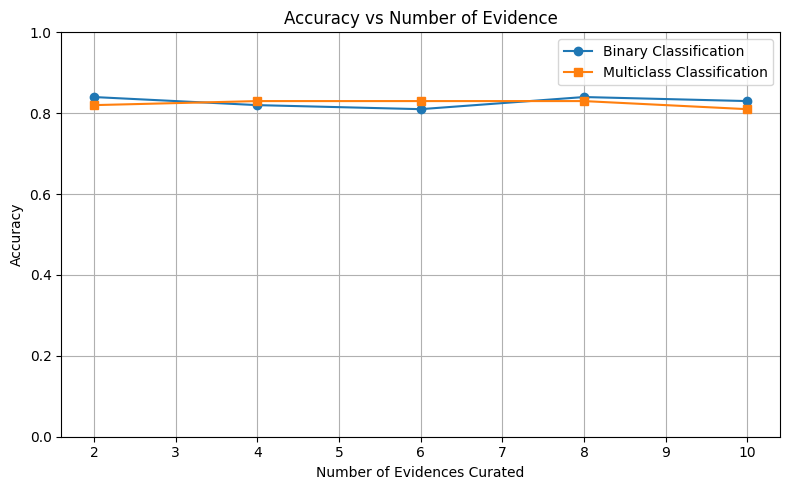

In [9]:
# Plotting
n_evidence = len(evidence_counts)

# Compute average accuracy across models for each task
avg_binary = [np.mean([accuracy_data[model]['binary'][i] for model in models]) for i in range(n_evidence)]
avg_multiclass = [np.mean([accuracy_data[model]['multiclass'][i] for model in models]) for i in range(n_evidence)]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(evidence_counts, avg_binary, marker='o', label='Binary Classification')
plt.plot(evidence_counts, avg_multiclass, marker='s', label='Multiclass Classification')

plt.title("Accuracy vs Number of Evidence")
plt.xlabel("Number of Evidences Curated")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Extract tags
# tags = [c['tag'] for c in curation_comp_json]
# predicted_tags = [c['predicted_tag'] for c in curation_comp_json]

# # Compute accuracy
# accuracy = np.mean([t == p for t, p in zip(tags, predicted_tags)])
# accuracy_bin = np.mean([t == p or (t != 'correct' and p == 'incorrect') for t, p in zip(tags, predicted_tags)])
# print(f"Accuracy: {accuracy:.2%}")
# print(f"Binary Accuracy: {accuracy_bin:.2%}")

# # Define tag label set
# tag_set = list(set(tags).union(set(predicted_tags)))

# # Compute confusion matrix
# cm = confusion_matrix(tags, predicted_tags, labels=tag_set)
# cm_df = pd.DataFrame(cm, index=tag_set, columns=tag_set)

# # Plot
# plt.figure(figsize=(12, 10))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5)
# plt.title("Confusion Matrix (Binary Classification - Model only predicts 'correct' or 'incorrect')")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()


In [14]:
get_curations(25933385922384546)


INFO: [2025-07-03 10:18:14] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/25933385922384546
INFO: [2025-07-03 10:18:14] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 10:18:14] indra.sources.indra_db_rest.util - data: None


[{'curator': 'ben.gyori@gmail.com',
  'date': 'Fri, 20 Mar 2020 22:05:13 GMT',
  'ev_json': None,
  'id': 2271,
  'pa_hash': 25933385922384546,
  'pa_json': None,
  'source': 'EMMAA',
  'source_hash': -8811343123534162720,
  'tag': 'correct',
  'text': ''},
 {'curator': 'ben.gyori@gmail.com',
  'date': 'Fri, 20 Mar 2020 22:09:05 GMT',
  'ev_json': None,
  'id': 2272,
  'pa_hash': 25933385922384546,
  'pa_json': None,
  'source': 'EMMAA',
  'source_hash': -8811343123534162720,
  'tag': 'act_vs_amt',
  'text': ''}]

In [18]:
len(stmt.evidence)


10

In [ ]:
pa_hash= -22774899934921350
source_hash= -8811343123534162720

print(json.dumps(get_curations(pa_hash), indent=2))
stmt = indra_db_rest.get_statements_by_hash([pa_hash], ev_limit=1000).statements[0]
print(stmt)
print(f"Number of evidences: {len(stmt.evidence)}")
for ev in stmt.evidence:
    if ev.source_hash == source_hash:
        print(ev.text)


INFO: [2025-07-03 10:22:18] indra.sources.indra_db_rest.util - query: https://db.indra.bio/curation/list/-22774899934921350
INFO: [2025-07-03 10:22:18] indra.sources.indra_db_rest.util - params: {'api_key': '[api-key]'}
INFO: [2025-07-03 10:22:18] indra.sources.indra_db_rest.util - data: None
INFO: [2025-07-03 10:22:19] indra_db_rest.query_processor - Retrieving statements that have hash -22774899934921350.
INFO: [2025-07-03 10:22:19] indra_db_rest.request_logs - Running 0th request for statements
INFO: [2025-07-03 10:22:19] indra_db_rest.request_logs -   LIMIT: None
INFO: [2025-07-03 10:22:19] indra_db_rest.request_logs -   OFFSET: 0


[
  {
    "curator": "bachmanjohn@gmail.com",
    "date": "Mon, 16 Dec 2019 18:22:39 GMT",
    "ev_json": null,
    "id": 694,
    "pa_hash": -22774899934921350,
    "pa_json": null,
    "source": "bioexp_paper_reach",
    "source_hash": -4480509786693004552,
    "tag": "correct",
    "text": ""
  },
  {
    "curator": "bachmanjohn@gmail.com",
    "date": "Mon, 16 Dec 2019 18:23:46 GMT",
    "ev_json": null,
    "id": 695,
    "pa_hash": -22774899934921350,
    "pa_json": null,
    "source": "bioexp_paper_reach",
    "source_hash": 9138363743468035398,
    "tag": "correct",
    "text": ""
  },
  {
    "curator": "bachmanjohn@gmail.com",
    "date": "Mon, 16 Dec 2019 18:24:38 GMT",
    "ev_json": null,
    "id": 696,
    "pa_hash": -22774899934921350,
    "pa_json": null,
    "source": "bioexp_paper_reach",
    "source_hash": -6407872722265349566,
    "tag": "entity_boundaries",
    "text": ""
  }
]
Complex(RAS(), TIAM1())
Number of evidences: 10
